In [3]:
###Import Statements
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import re
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [4]:
#Read the data
df = pd.read_csv('/kaggle/input/youtube/youtube.csv')
df.head(2)

,index,video_id,trending_date,title,channel_title,category_id,publish_date,time_frame,published_day_of_week,publish_country,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed
0,0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,13/11/2017,17:00 to 17:59,Monday,US,SHANtell martin,748374,57527,2966,15954,False,False,False
1,1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,13/11/2017,7:00 to 7:59,Monday,US,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,False,False,False


In [ ]:
#Data Cleanup
stop_words = set(stopwords.words('english'))
type(stop_words)
list(stop_words)[:10]

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df['title_tokens'] =df['title'].apply(preprocess_text)
# df['tags_tokens'] = df['tags'].apply(preprocess_text)

In [ ]:
#Split video tags to get frequency later
df['tags_word_count'] = df['tags'].apply(lambda x: len(str(x).split("|")))

### Sentiment code starts

In [16]:
df.head(3)

#create a new data frame with "id" and "comment" fields
df_subset = df[['index', 'title']].copy()
df_subset = df_subset.head(500)

#data clean-up
#remove all non-aphabet characters
df_subset['title'] = df_subset['title'].str.replace("[^a-zA-Z#]", " ")

#covert to lower-case
df_subset['title'] = df_subset['title'].astype(str).str.casefold()

In [17]:
print (df_subset.head(10))

   index                                              title
0      0                 we want to talk about our marriage
1      1  the trump presidency: last week tonight with j...
2      2  racist superman | rudy mancuso, king bach & le...
3      3                   nickelback lyrics: real or fake?
4      4                           i dare you: going bald!?
5      5                              2 weeks with iphone x
6      6          roy moore & jeff sessions cold open - snl
7      7                5 ice cream gadgets put to the test
8      8  the greatest showman | official trailer 2 [hd]...
9      9  why the rise of the robots wonâ€™t mean the en...


In [20]:
# set up empty dataframe for staging output
df1=pd.DataFrame()
df1['index']=['99999999999']
df1['sentiment_type']='NA999NA'
df1['sentiment_score']=0

sid = SentimentIntensityAnalyzer()
t_df = df1

for index, row in df_subset.iterrows():
    scores = sid.polarity_scores(row[1])
    for key, value in scores.items():
        temp = [key,value,row[0]]
        df1['index']=row[0]
        df1['sentiment_type']=key
        df1['sentiment_score']=value
        t_df=t_df._append(df1,ignore_index=True)
        
        

In [21]:
#remove dummy row with row_id = 99999999999
t_df_cleaned = t_df[t_df.index != '99999999999']
#remove duplicates if any exist
t_df_cleaned = t_df_cleaned.drop_duplicates()
# only keep rowreplace where sentiment_type = compound
t_df_cleaned = t_df[t_df.sentiment_type == 'compound']
print(t_df_cleaned.head(10))

    index sentiment_type  sentiment_score
4       0       compound           0.0772
8       1       compound           0.0000
12      2       compound          -0.6124
16      3       compound          -0.4767
20      4       compound           0.0000
24      5       compound           0.0000
28      6       compound           0.0000
32      7       compound           0.0000
36      8       compound           0.6369
40      9       compound           0.0000


In [22]:
#merge dataframes
df_output = pd.merge(df, t_df_cleaned, on='index', how='inner')
print(df_output.head(10))

   index     video_id trending_date  \
0      0  2kyS6SvSYSE      17.14.11   
1      1  1ZAPwfrtAFY      17.14.11   
2      2  5qpjK5DgCt4      17.14.11   
3      3  puqaWrEC7tY      17.14.11   
4      4  d380meD0W0M      17.14.11   
5      5  gHZ1Qz0KiKM      17.14.11   
6      6  39idVpFF7NQ      17.14.11   
7      7  nc99ccSXST0      17.14.11   
8      8  jr9QtXwC9vc      17.14.11   
9      9  TUmyygCMMGA      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   
5                              2 Weeks with iPhone X               iJustine   
6          Roy Mo

In [23]:
df_output[["sentiment_score"]].describe()

df_output[(df_output.sentiment_score) <0.0].head(3)

In [24]:
df_output.to_excel('Sample Sentiment Score of Video Titles.xlsx')

### Sentiment Code ends here

In [8]:
#Channel Analysis
channel_frequency = df['channel_title'].value_counts()

channel_avg_views = df.groupby('channel_title')['views'].mean()
channel_avg_likes = df.groupby('channel_title')['likes'].mean()
channel_analysis = pd.DataFrame({
    'Frequency': channel_frequency, 
    'Average Views': channel_avg_views, 
    'Average Likes': channel_avg_likes
})

In [28]:
#Channel Title Words Frequency Analysis 
top_channels = channel_analysis.sort_values(by='Frequency', ascending=False).head(10)
top_channels

,Frequency,Average Views,Average Likes
channel_title,,,
The Late Show with Stephen Colbert,653,9.798337e+05,13573.235835
Late Night with Seth Meyers,594,1.286973e+06,16207.787879
TheEllenShow,586,1.607622e+06,40759.691126
The Tonight Show Starring Jimmy Fallon,569,1.741568e+06,40840.321617
Jimmy Kimmel Live,560,1.709554e+06,32892.458929
WWE,545,2.458111e+06,34533.264220
CNN,495,9.935644e+05,11637.587879
The Late Late Show with James Corden,494,2.061846e+06,63332.852227
Netflix,476,1.495447e+06,36528.745798


In [30]:
top_channels.to_excel('High Frequency Channels.xlsx')

In [12]:
# Channel Analysis: Top Channels by views
df['engagement_score'] = df['views'] + df['likes'] + df['comment_count']


In [40]:
word_counts = title_matrix.sum(axis=0).A1
word_count_dict = dict(zip(title_words, word_counts))
sorted_word_counts = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)
sorted_word_counts[:20]

[('tv', 4258),
 ('news', 2830),
 ('late', 2237),
 ('channel', 1496),
 ('live', 1482),
 ('entertainment', 1408),
 ('le', 1188),
 ('official', 1162),
 ('pictures', 1154),
 ('jimmy', 1153),
 ('officiel', 1021),
 ('music', 1006),
 ('night', 1005),
 ('la', 963),
 ('troom', 900),
 ('bbc', 872),
 ('france', 837),
 ('tonight', 763),
 ('fox', 739),
 ('daily', 735)]

In [45]:
sorted_word_counts_df = pd.DataFrame(sorted_word_counts[0:], columns=(['Word', 'Frequency']))

In [82]:
text = " ".join(df['channel_title'])

In [83]:
wordcloud2 = WordCloud(background_color='white', width=480, height=480, margin=0).generate(text)

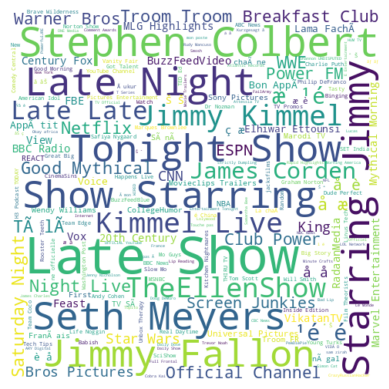

In [84]:
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

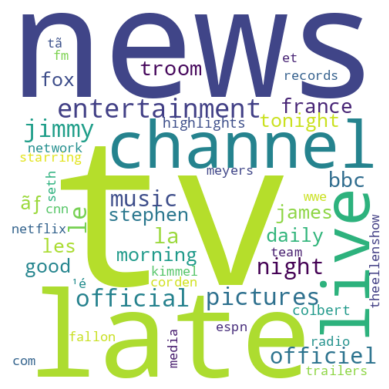

In [61]:
# Create a list of words and their frequencies 
words = [] 
for index, row in sorted_word_counts_df.iterrows(): 
    words.append((row['Word'], row['Frequency']))

data = sorted_word_counts_df.set_index('Word').to_dict()['Frequency']

wordcloud = WordCloud(background_color='white', width=480, height=480, margin=0).generate_from_frequencies(data)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [62]:
plt.savefig('WordCloud.png')

<Figure size 640x480 with 0 Axes>

In [18]:
sorted_word_counts_df.head(10)

,Word,Frequency
0,tv,4258
1,news,2830
2,late,2237
3,channel,1496
4,live,1482
5,entertainment,1408
6,le,1188
7,official,1162
8,pictures,1154
9,jimmy,1153


In [54]:
# Channel Analysis: Top Channels by Likes
top_channels_likes = df.groupby(['channel_title','tags_word_count', 'tags'])['likes'].sum().sort_values(ascending=False).head(10)

# Channel Analysis: Top Channels by Comments
top_channels_comments = df.groupby(['channel_title','tags_word_count', 'tags'])['comment_count'].sum().sort_values(ascending=False).head(10)

In [ ]:
##Exporting for Power BI Input
top_channels_views.to_excel('top_channels_views.xlsx')

In [ ]:
top_channels_likes.to_excel('top_channels_likes.xlsx')
top_channels_comments.to_excel('top_channels_comments.xlsx')

In [28]:
# Channel Analysis: Top Channels by views
top_channels_views = df.groupby(['channel_title','tags_word_count', 'tags'])['views'].sum().sort_values(ascending = False).head(10)
##top_channels_views.head(10)

In [56]:
top_channels_views = top_channels_views.to_frame().reset_index()

In [57]:
top_channels_likes = top_channels_likes.to_frame().reset_index()
top_channels_comments = top_channels_comments.to_frame().reset_index()

In [17]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df['title_tokens'] =df['title'].apply(preprocess_text)
df['tags_tokens'] = df['tags'].apply(preprocess_text)

In [ ]:
df.head(5)

In [53]:
##Word count of Channels with Top Views

top_channels_views['tags_tokens'] = top_channels_views['tags'].apply(preprocess_text)

all_tags_tokens = [token for sublist in top_channels_views['tags_tokens'] for token in sublist]

# Get the most common words in titles and tags
top_tags_words = Counter(all_tags_tokens).most_common(10)

top_tags_words_df = pd.DataFrame(top_tags_words[0:], columns=top_tags_words[0])

top_tags_words_df = top_tags_words_df.rename(columns = {'natti':'Tags'})
top_tags_words_df = top_tags_words_df.rename(columns = {12:'Frequency'}) 

In [71]:
top_tags_words_df.to_excel('Top Views Tags Frequency.xlsx')

In [67]:
##Word count of Channels with Top Comments

top_channels_comments['tags_tokens'] = top_channels_comments['tags'].apply(preprocess_text)

all_tags_token_v2 = [token for sublist in top_channels_comments['tags_tokens'] for token in sublist]

# Get the most common words in titles and tags
top_tags_words_v2 = Counter(all_tags_token_v2).most_common(10)

top_tags_words_v2_df = pd.DataFrame(top_tags_words_v2[0:], columns=top_tags_words_v2[0])

top_tags_words_v2_df = top_tags_words_v2_df.rename(columns = {'paul':'Tags'})
top_tags_words_v2_df = top_tags_words_v2_df.rename(columns = {13:'Frequency'}) 

In [72]:
top_tags_words_v2_df.to_excel('Top Comments Tags Frequency.xlsx')

In [70]:
##Word count of Channels with Top Likes

top_channels_likes['tags_tokens'] = top_channels_likes['tags'].apply(preprocess_text)

all_tags_token_v3 = [token for sublist in top_channels_likes['tags_tokens'] for token in sublist]

# Get the most common words in titles and tags
top_tags_words_v3 = Counter(all_tags_token_v3).most_common(10)

top_tags_words_v3_df = pd.DataFrame(top_tags_words_v3[0:], columns=top_tags_words_v3[0])

top_tags_words_v3_df = top_tags_words_v3_df.rename(columns = {'drake':'Tags'})
top_tags_words_v3_df = top_tags_words_v3_df.rename(columns = {6:'Frequency'}) 

In [73]:
top_tags_words_v3_df.to_excel('Top Likes Tags Frequency.xlsx')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


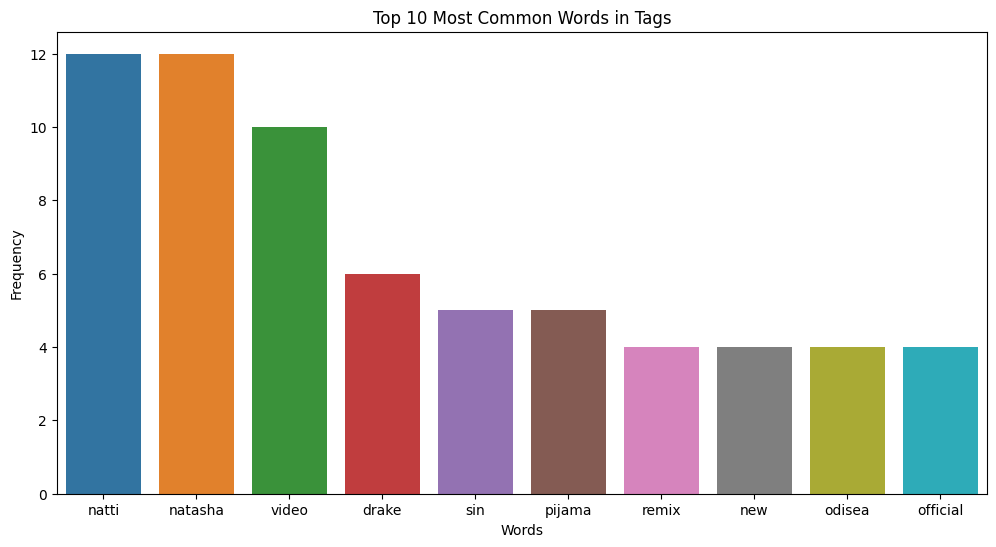

In [36]:
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in top_tags_words], y=[word[1] for word in top_tags_words])
plt.title('Top 10 Most Common Words in Tags')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()